In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,time
import tensorflow.keras as keras
from PIL import Image
from sklearn.model_selection import train_test_split
from random import randrange

In [2]:
def graph_and_sort_attr(df,order,save_as=None):
    """
        Función para graficar y seleccionar las clases dependiendo del 
        orden que se defina
        :param df: DataFrame principal
        :param order: Define el orden para elegir las clases
                0 = mayor número de presencia
                1 = menor número de presencia
                2 = random
        :param save_as: Nombre como se guardará la gráfica si así se desea.
        :return lista con las clases a utilizar
    """
    headers = list(df)[1:]
    dfs = df[headers][df[headers] > 0].sum()
    dfsort = dfs.sort_values()
    dfsort.plot(kind = "bar")
    plt.xlabel("Attributes")
    plt.ylabel("N. of images")
    if save_as:
        plt.savefig(os.path.join("./",save_as))
    plt.show()
    if order == 0:
        return list(dfsort.index[-4:])
    elif order == 1:
        return list(dfsort.index[:4])
    elif order == 2:
        heads = []
        rand_generated = []
        x = 0
        while x < 4:
            r_num = randrange(len(headers))
            if not r_num in rand_generated:
                rand_generated.append(r_num)
                heads.append(headers[r_num])
                x+=1

        return heads 
    else:
        return None

In [3]:
def group_data(df_attr,classes_selected,low_performance=False):
    """
        Función que selecciona y agrupa el nombre de la imagen con base en los 
        atributos definidos
        :param df_attr: DataFrame de los atributos
        :param classes_selected: nombre de las classes o atributos definidos
        :low_performance: bandera para definir si el dataset debe de ser recortado
                        a un límite de 8000 imágenes por clase.
                        Dependiendo de los recursos que se tengan.
        :return DataFrame: DataFrame con las classes y sus respectivos nombres de las imágenes 
                        que pertenecen a las mismas
    """
    df_grouped = df_attr.groupby(classes_selected)["image_id"].unique()
    img_list = []
    for idx, item in df_grouped.items():
        i = 0
        for ix in idx:
            if ix == 1:
                img_list.append([classes_selected[i],item])
                break
            i+=1

    if low_performance:
        print("Low Performance activado!")
        low_img_list=[]
        for c in classes_selected:
            obj = list()
            for il in img_list:
                if c == il[0]:
                    obj += list(il[1])
            low_img_list.append([c,obj])
        img_list = low_img_list[:]
        for i in range(len(img_list)):
            if len(img_list[i][1]) > 8000:
                print("Clase '{}' pasa de {} a 8000 imágenes".format(img_list[i][0],len(img_list[i][1])))
                img_list[i][1] = img_list[i][1][:8000]

    return pd.DataFrame(img_list,columns=["label","img_name"])

In [4]:
def train_model(dataset, epochs, batch_size, image_size=(64,64), test_split=0.2):
    """
        Esta función se encarga de entrenar el modelo.
        :param dataset: dataset con las imágenes definidas para trabajar.
        :param epoch: número de epocas a entrenar el modelo.
        :param batch_size: tamaño del batch ocupado para entrenar
        :param image_size: tamaño (w,h) de las imágenes para redimensionar
        :param test_split: relación de tamaño de train, test, val
        :return: modelo entrenado
    """
    dict_attr = {}
    for idx,row in dataset.iterrows():
        dict_attr.update({row['label']:0})
    
    # print("Tamaño total del dataset: {}".format(len(dataset)))
    INIT_LR = 1e-3 #valor inicial de learning rate
    labels = []
    images_x = []
    labels_y = [] 

    for cls_s in dataset['label'].unique():
        labels.append(cls_s)

    for idxL in range(len(labels)):
        print(idxL,labels[idxL])

    dataset_size = 0
    for idx,row in dataset.iterrows():
        dict_attr.update({row["label"]:dict_attr[row["label"]]+len(row["img_name"])})
        dataset_size += len(row["img_name"])

    for key in dict_attr.keys():
        print("{}: {}".format(key,dict_attr[key]))

    print("Tamaño total del dataset: ",dataset_size)
    print("Cargando las imágenes en memoria, esto puede tardar un tiempo dependiendo el tamaño del dataset...")
    
    for idx,row in dataset.iterrows():
        for img_name in row["img_name"]:
            labels_y.append(labels.index(row["label"]))
            image = Image.open(os.path.join("./celeba-dataset/img_align_celeba/",img_name))
            new_image = image.resize(image_size)
            images_x.append(np.array(new_image))
    
    labels_y = np.array(labels_y)
    images_x = np.array(images_x, dtype=np.uint8)

    print(len(labels_y))

    #dividir el dataset en train, val and test. Relación 80%-20%
    train_x,test_x,train_y,test_y = train_test_split(images_x,labels_y,test_size=test_split)
    train_x = train_x.astype('float32')
    test_x = test_x.astype('float32')
    train_x = train_x / 255.
    test_x = test_x / 255.

    train_y_one_hot = keras.utils.to_categorical(train_y)
    test_y_one_hot = keras.utils.to_categorical(test_y)

    train_x,val_x,train_label,val_label = train_test_split(train_x, train_y_one_hot, test_size=test_split, random_state=13)

    # Definiendo las capas para el entrenamiento
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(image_size[0],image_size[1],3)))
    model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D((2, 2),padding='same'))
    model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation='linear'))
    model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.Dropout(0.5)) 
    model.add(keras.layers.Dense(len(labels), activation='softmax'))

    model.summary()

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])
    train_model_out = model.fit(train_x, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(val_x, val_label))

    test_eval = model.evaluate(test_x, test_y_one_hot, verbose=1)
    
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    return train_model_out

In [5]:
def graph_model(model,value='accuracy',save_as=None):
    """
        Método para graficar los resultados del modelo entrenado
        ['accuracy','loss','val_loss','val_accuracy']
        :param model: modelo entrenado a graficar
        :param value: valor a graficar ['accuracy','loss']
        :param save_as: Nombre como se guardará la gráfica si así se desea.
    """
    plt.plot(model.history[value])
    plt.plot(model.history['val_{}'.format(value)])
    plt.title('Model {}'.format(value))
    plt.ylabel('{}'.format(value))
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save_as:
        plt.savefig(os.path.join("./",save_as))
    plt.show()

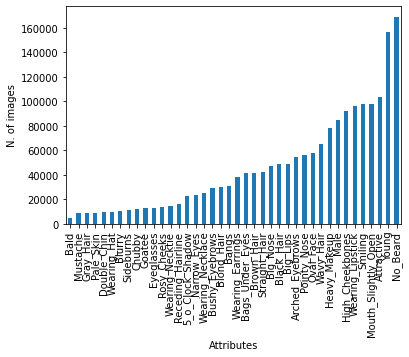

0 Pale_Skin
1 Gray_Hair
2 Mustache
3 Bald
Pale_Skin: 8303
Gray_Hair: 6871
Mustache: 7751
Bald: 4547
Tamaño total del dataset:  27472
Cargando las imágenes en memoria, esto puede tardar un tiempo dependiendo el tamaño del dataset...
27472
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
________________

Epoch 43/250
17581/17581 [==============================] - 8s 477us/sample - loss: 0.6604 - accuracy: 0.7295 - val_loss: 0.5841 - val_accuracy: 0.7666
Epoch 44/250
17581/17581 [==============================] - 8s 466us/sample - loss: 0.6618 - accuracy: 0.7314 - val_loss: 0.5803 - val_accuracy: 0.7668
Epoch 45/250
17581/17581 [==============================] - 8s 464us/sample - loss: 0.6536 - accuracy: 0.7312 - val_loss: 0.5814 - val_accuracy: 0.7671
Epoch 46/250
17581/17581 [==============================] - 8s 471us/sample - loss: 0.6507 - accuracy: 0.7380 - val_loss: 0.5763 - val_accuracy: 0.7714
Epoch 47/250
17581/17581 [==============================] - 8s 471us/sample - loss: 0.6454 - accuracy: 0.7388 - val_loss: 0.5775 - val_accuracy: 0.7712
Epoch 48/250
17581/17581 [==============================] - 8s 483us/sample - loss: 0.6451 - accuracy: 0.7372 - val_loss: 0.5729 - val_accuracy: 0.7682
Epoch 49/250
17581/17581 [==============================] - 8s 474us/sample - loss: 0.64

Epoch 97/250
17581/17581 [==============================] - 8s 444us/sample - loss: 0.5754 - accuracy: 0.7748 - val_loss: 0.5180 - val_accuracy: 0.7980
Epoch 98/250
17581/17581 [==============================] - 8s 454us/sample - loss: 0.5750 - accuracy: 0.7753 - val_loss: 0.5152 - val_accuracy: 0.7987
Epoch 99/250
17581/17581 [==============================] - 8s 447us/sample - loss: 0.5789 - accuracy: 0.7728 - val_loss: 0.5131 - val_accuracy: 0.7994
Epoch 100/250
17581/17581 [==============================] - 8s 447us/sample - loss: 0.5791 - accuracy: 0.7692 - val_loss: 0.5167 - val_accuracy: 0.7991
Epoch 101/250
17581/17581 [==============================] - 8s 450us/sample - loss: 0.5710 - accuracy: 0.7741 - val_loss: 0.5122 - val_accuracy: 0.8010
Epoch 102/250
17581/17581 [==============================] - 8s 455us/sample - loss: 0.5729 - accuracy: 0.7783 - val_loss: 0.5125 - val_accuracy: 0.8035
Epoch 103/250
17581/17581 [==============================] - 8s 452us/sample - loss: 

17581/17581 [==============================] - 8s 453us/sample - loss: 0.5349 - accuracy: 0.7936 - val_loss: 0.4886 - val_accuracy: 0.8094
Epoch 151/250
17581/17581 [==============================] - 8s 448us/sample - loss: 0.5390 - accuracy: 0.7893 - val_loss: 0.4876 - val_accuracy: 0.8085
Epoch 152/250
17581/17581 [==============================] - 8s 456us/sample - loss: 0.5347 - accuracy: 0.7935 - val_loss: 0.4875 - val_accuracy: 0.8105
Epoch 153/250
17581/17581 [==============================] - 8s 457us/sample - loss: 0.5396 - accuracy: 0.7920 - val_loss: 0.4873 - val_accuracy: 0.8121
Epoch 154/250
17581/17581 [==============================] - 8s 447us/sample - loss: 0.5351 - accuracy: 0.7927 - val_loss: 0.4858 - val_accuracy: 0.8096
Epoch 155/250
17581/17581 [==============================] - 8s 467us/sample - loss: 0.5300 - accuracy: 0.7950 - val_loss: 0.4860 - val_accuracy: 0.8110
Epoch 156/250
17581/17581 [==============================] - 8s 464us/sample - loss: 0.5334 - ac

17581/17581 [==============================] - 8s 469us/sample - loss: 0.5137 - accuracy: 0.8023 - val_loss: 0.4734 - val_accuracy: 0.8167
Epoch 204/250
17581/17581 [==============================] - 8s 471us/sample - loss: 0.5060 - accuracy: 0.8066 - val_loss: 0.4730 - val_accuracy: 0.8169
Epoch 205/250
17581/17581 [==============================] - 8s 461us/sample - loss: 0.5129 - accuracy: 0.8036 - val_loss: 0.4726 - val_accuracy: 0.8160
Epoch 206/250
17581/17581 [==============================] - 8s 461us/sample - loss: 0.5115 - accuracy: 0.8025 - val_loss: 0.4722 - val_accuracy: 0.8167
Epoch 207/250
17581/17581 [==============================] - 8s 460us/sample - loss: 0.5102 - accuracy: 0.8033 - val_loss: 0.4720 - val_accuracy: 0.8171
Epoch 208/250
17581/17581 [==============================] - 8s 461us/sample - loss: 0.5072 - accuracy: 0.8046 - val_loss: 0.4719 - val_accuracy: 0.8164
Epoch 209/250
17581/17581 [==============================] - 8s 459us/sample - loss: 0.5109 - ac

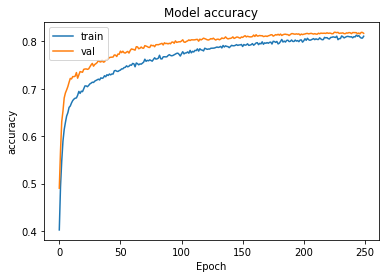

In [6]:
#carga el dataframe de los atributos
path_attr = "celeba-dataset/list_attr_celeba.csv"
df_attr = pd.read_csv(path_attr)
# Selecciona las clases a entrenar
classes_selected = graph_and_sort_attr(df_attr,1,save_as="attr_graph.jpg")
# selecciona y agrupa las imágenes dependiendo de las clases a entrenar en un nuevo DataFrame
dataset = group_data(df_attr,classes_selected)
# proceso para entrenar el modelo
trained_model = train_model(dataset,250,64)
# método para graficar los resultados del modelo
graph_model(trained_model,save_as="val_graph.jpg")